# 🔬 CNN Model Evaluation and Verification

This notebook allows you to load a trained model checkpoint (`.pth`), specify a dataset (CSV files), and evaluate the model's performance by generating metrics and a confusion matrix.

## 1. Import Libraries and Modules

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import modular components
from cnn_model import CNNmodel
from emg_preprocessing import preprocess, EMGDataset, N_CHANNELS, FS, WINDOW_SIZE, STRIDE, NPERSEG, NOVERLAP

print("Libraries and modules imported successfully.")

Libraries and modules imported successfully.


## 2. Configuration and Setup

In [2]:
# --- USER-DEFINED PARAMETERS ---
BATCH_SIZE = 32

# 1. MODEL AND WEIGHTS PATHS
MODEL_WEIGHTS_PATH = "train_single_subject_myo_model.pth" # Path to the saved .pth file
NORMALIZATION_PARAMS_PATH = "normalization_params.npy"  # Path to the saved mean/std

# 2. LABELS AND CLASSES
LABELS = {"rest": 0, "pinch": 1}
CLASS_NAMES = ["rest", "pinch"]

# 3. INPUT DATA FILES (Use the same files or new unseen files)
EVAL_DATA_FILES = [
    ("../myo/samples/raymond_arm_90_deg_200hz.csv", LABELS["rest"]),
    ("../myo/samples/raymond_arm_90_deg_pinch_200hz.csv", LABELS["pinch"]),
    ("../myo/samples/raymond_arm_down_200hz.csv", LABELS["rest"]),
    ("../myo/samples/raymond_arm_down_pinch_200hz.csv", LABELS["pinch"])
]

# --- DEVICE SETUP ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: mps


## 3. Load Normalization Parameters

In [3]:
try:
    params = np.load(NORMALIZATION_PARAMS_PATH, allow_pickle=True).item()
    GLOBAL_MEAN = params['mean']
    GLOBAL_STD = params['std']
    print(f"Normalization parameters loaded from {NORMALIZATION_PARAMS_PATH}.")
except FileNotFoundError:
    raise FileNotFoundError(
        f"Error: Normalization file not found at {NORMALIZATION_PARAMS_PATH}. \n"
        "Ensure you run `train_cnn.ipynb` successfully first."
    )

Normalization parameters loaded from normalization_params.npy.


## 4. Load, Preprocess, and Normalize Data

In [4]:
X_all = []
Y_all = []

print("Preprocessing all evaluation data files...")

for path, label in EVAL_DATA_FILES:
    print(f"Processing file: {path} with label: {label}")
    
    # 1. Preprocess (Filter, STFT, Log-Spectrogram) - using logic from emg_preprocessing.py
    X_specs = preprocess(path)
    
    if X_specs.size > 0:
        X_all.append(X_specs)
        Y_all.append(np.full(X_specs.shape[0], label, dtype=np.int64))

X_all = np.concatenate(X_all)
Y_all = np.concatenate(Y_all)

print(f"Total evaluation windows collected: {len(X_all)}")

# 2. Apply Normalization using the loaded GLOBAL_MEAN and GLOBAL_STD
X_normalized = (X_all - GLOBAL_MEAN) / GLOBAL_STD

print("Data successfully normalized.")

Preprocessing all evaluation data files...
Processing file: ../myo/samples/raymond_arm_90_deg_200hz.csv with label: 0
Processing file: ../myo/samples/raymond_arm_90_deg_pinch_200hz.csv with label: 1
Processing file: ../myo/samples/raymond_arm_down_200hz.csv with label: 0
Processing file: ../myo/samples/raymond_arm_down_pinch_200hz.csv with label: 1
Total evaluation windows collected: 4912
Data successfully normalized.


## 5. Load Model and Weights

In [5]:
# Create the Dataset and DataLoader
eval_dataset = EMGDataset(X_normalized, Y_all)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of batches in evaluation set: {len(eval_loader)}")

# Initialize Model (We use LR=0 as we are not training)
model = CNNmodel(
    in_channels=N_CHANNELS, 
    num_classes=len(LABELS), 
    learning_rate=0, 
    device=DEVICE
) 

try:
    # Load state dictionary from the saved checkpoint
    model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
    print(f"Model weights loaded successfully from {MODEL_WEIGHTS_PATH}.")
except FileNotFoundError:
    raise FileNotFoundError(
        f"Error: Model weights not found at {MODEL_WEIGHTS_PATH}.\n"
        "Please check the path and ensure you have run `train_cnn.ipynb`."
    )

print("Model ready for evaluation.")

Number of batches in evaluation set: 154
Model weights loaded successfully from train_single_subject_myo_model.pth.
Model ready for evaluation.


## 6. Run Evaluation

In [6]:
print(f"Starting evaluation on {DEVICE}...")

# Use the model's built-in test_epoch method
eval_acc, preds_all, labels_all = model.test_epoch(eval_loader)

print("\n--- Evaluation Complete ---")
print(f"Total Samples: {len(labels_all)}")
print(f"Final Accuracy: {eval_acc:.4f}")

Starting evaluation on mps...

--- Evaluation Complete ---
Total Samples: 4912
Final Accuracy: 0.8730


## 7. Visualize Results

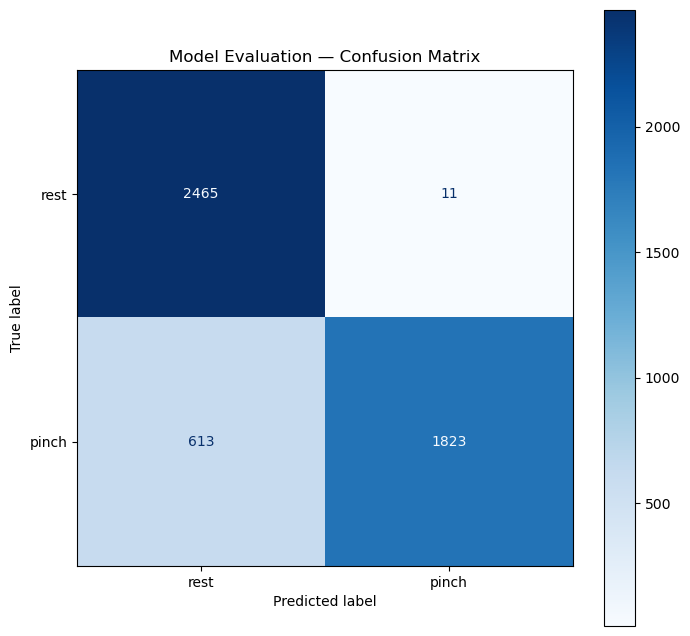

In [7]:
# Confusion Matrix
cm = confusion_matrix(labels_all, preds_all, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Model Evaluation — Confusion Matrix")
plt.show()